# Pixel Sides

Este é um projeto para a disciplina de Aprendizado de Máquina do DCC/UFMG em 2021/1, ministrada por Adriano Veloso.
Autor: Flávio Coutinho <fegemo@cefetmg.br>

A ideia é, dada a imagem frontal de um personagem em pixel art (64x64), gerar as visões laterais e de costas dele.

Foi usado o _dataset_ Tiny Pixel ....

A implementação usa Pix2Pix... ou ...CycleGAN?

Passos:
1. Criar um classificador de pose usando _transfer learning_ de MobileNET v2?
1. Criar uma DCGAN?
1. Treinar Pix2Pix?
1. Treinar CycleGAN?

In [67]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print("Versão do TensorFlow: ", tf.__version__)

import PIL
import imageio
from IPython import display


Versão do TensorFlow:  2.5.0


In [2]:
seed = 42
np.random.seed(seed)

data_folder = "tiny-hero"
batch_size = 100 
image_size = 64

channels = 3

#latent_size = 40
#condition_size = 10
#feature_map_size = 64
#num_epochs = 200

#lr_d = 0.0004
#lr_g = 0.0001
#beta1 = 0.5
#ngpu = 1


## 1. Criando o _dataset_ para classificador

In [3]:
X_train = tf.keras.preprocessing.image_dataset_from_directory(
  data_folder,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(image_size, image_size),
  batch_size=batch_size)

X_validation = tf.keras.preprocessing.image_dataset_from_directory(
  data_folder,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(image_size, image_size),
  batch_size=batch_size)


Found 3648 files belonging to 4 classes.
Using 2919 files for training.
Found 3648 files belonging to 4 classes.
Using 729 files for validation.


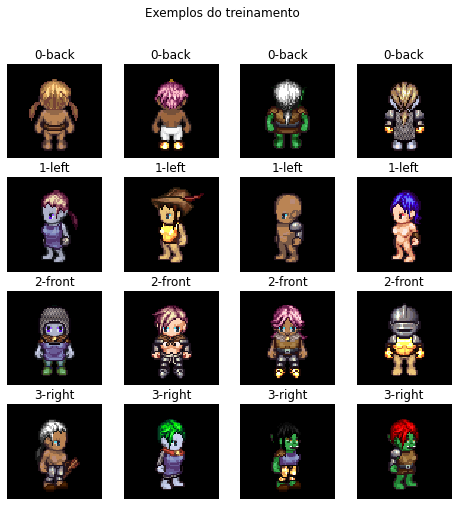

In [4]:
class_names = X_train.class_names

plt.figure(figsize=(8, 8))
plt.suptitle("Exemplos do treinamento")
for i in range(4):
    X_train_by_class = X_train.filter(lambda x, l: tf.math.equal(l[0], i))
    for j in range(4):
        for images, labels in X_train_by_class.take(1):
            ax = plt.subplot(4, 4, (i*4+j)+1)
            plt.imshow(images[0].numpy().astype("uint8"), interpolation="nearest")
            plt.title(class_names[labels[0]])
            plt.axis("off")

In [5]:
X_train = X_train.cache().shuffle(1000, seed=seed).prefetch(buffer_size=tf.data.AUTOTUNE)
X_validation = X_validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
pose_classifier = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_size, image_size, 3))
    layers.Conv2D(2, 3, padding="same", activation="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(4, 3, padding="same", activation="relu"),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(24),
    layers.Dense(len(class_names), activation="softmax")
])

pose_classifier.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

pose_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 2)         56        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                2

In [7]:
epochs = 10
history = pose_classifier.fit(
  X_train,
  validation_data=X_validation,
  epochs=epochs
)

Epoch 1/10
30/30 [==============================] - 4s 25ms/step - loss: 0.9512 - accuracy: 0.8229 - val_loss: 0.4529 - val_accuracy: 0.9671
Epoch 2/10
30/30 [==============================] - 0s 9ms/step - loss: 0.2046 - accuracy: 0.9794 - val_loss: 0.0810 - val_accuracy: 0.9931
Epoch 3/10
30/30 [==============================] - 0s 9ms/step - loss: 0.0511 - accuracy: 0.9928 - val_loss: 0.0400 - val_accuracy: 0.9959
Epoch 4/10
30/30 [==============================] - 0s 9ms/step - loss: 0.0336 - accuracy: 0.9938 - val_loss: 0.0251 - val_accuracy: 0.9973
Epoch 5/10
30/30 [==============================] - 0s 9ms/step - loss: 0.0193 - accuracy: 0.9976 - val_loss: 0.0171 - val_accuracy: 0.9959
Epoch 6/10
30/30 [==============================] - 0s 9ms/step - loss: 0.0150 - accuracy: 0.9976 - val_loss: 0.0143 - val_accuracy: 0.9973
Epoch 7/10
30/30 [==============================] - 0s 9ms/step - loss: 0.0119 - accuracy: 0.9983 - val_loss: 0.0151 - val_accuracy: 0.9986
Epoch 8/10
30/30 [=

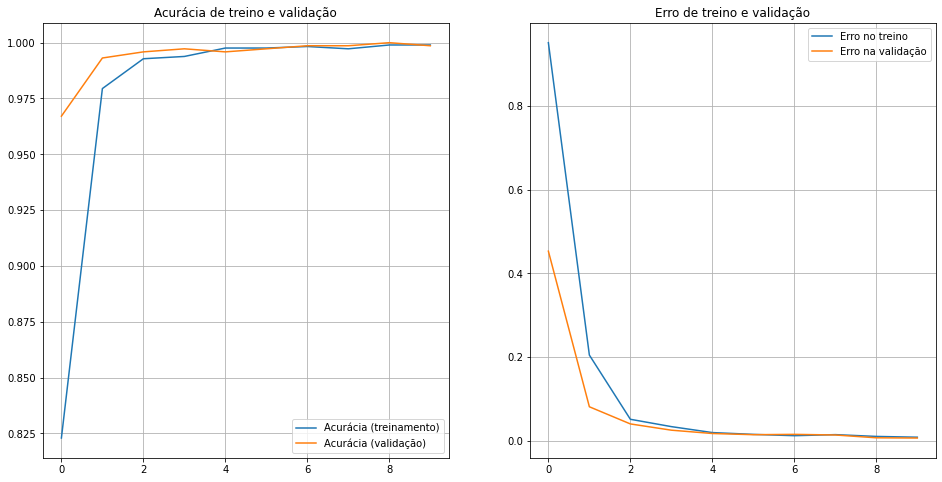

In [8]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Acurácia (treinamento)")
plt.plot(epochs_range, val_acc, label="Acurácia (validação)")
plt.legend(loc="lower right")
plt.grid()
plt.title("Acurácia de treino e validação")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Erro no treino")
plt.plot(epochs_range, val_loss, label="Erro na validação")
plt.legend(loc="upper right")
plt.title("Erro de treino e validação")
plt.grid()
plt.show()

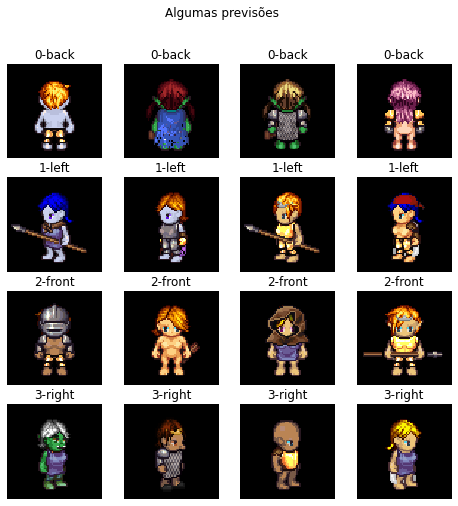

In [9]:
Y_predicted = np.argmax(pose_classifier.predict(X_validation), axis=1).astype(int).reshape(729, 1)
X_validation_unbatched = np.array(list(X_validation.unbatch().as_numpy_iterator()), dtype=object)
X_validation_unbatched = np.concatenate((X_validation_unbatched, Y_predicted), axis=1)

X_validation_by_class = dict()
for c, (image, y, y_hat) in enumerate(X_validation_unbatched):
    if y_hat not in X_validation_by_class:
        X_validation_by_class[y_hat] = []
    X_validation_by_class[y_hat].append((image, y, y_hat))

plt.figure(figsize=(8, 8))
plt.suptitle("Algumas previsões")
for i, class_name in enumerate(class_names):
    indices = np.arange(len(X_validation_by_class[i]), dtype="int")
    indices = np.random.choice(indices, size=4)
    examples_from_current_class = np.array(X_validation_by_class[i], dtype=object)[indices]
    for j in range(4):
        ax = plt.subplot(4, 4, (i*4+j)+1)
        plt.imshow(examples_from_current_class[j][0].astype("uint8"), interpolation="nearest")
        plt.title(class_names[examples_from_current_class[j][2]])
        plt.axis("off")


**Ideias pra aumentar aqui**:
1. Mostrar as que foram erradas e fazer análise
2. Testar com outras imagens pixel art
3. Testar com fotos ou imagens de alta resolução (reduzidas para 64x64)

## Criando uma DCGAN para gerar novos personagens

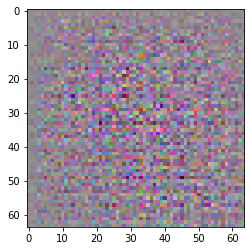

In [141]:
def build_generator():
    return Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Reshape((8, 8, 256)),
        
        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(16, (5,5), strides=(2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh"),
        layers.experimental.preprocessing.Rescaling(255)
    ])

generator = build_generator()

noise = tf.random.normal([1, 100])
sample_generated_image = generator(noise, training=False)


def show_generated_image(image):
    image_min = tf.math.reduce_min(image)
    image_max = tf.math.reduce_max(image)
    plt.imshow((image + tf.math.abs(image_min)) / (image_max - image_min))
#     plt.imshow(image)

# print(sample_generated_image_min)
# print(sample_generated_image_max)
# print(sample_generated_image_max-sample_generated_image_min)
# plt.imshow(tf.clip_by_value(sample_generated_image[0], clip_value_min=0., clip_value_max=1.))
# print((sample_generated_image[0] + tf.math.abs(sample_generated_image_min)) / (sample_generated_image_max - sample_generated_image_min))
show_generated_image(sample_generated_image[0])



In [142]:
def build_discriminator():
    return Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", activation="relu"),
        layers.LeakyReLU(),
        
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same", activation="relu"),
        layers.LeakyReLU(),

        layers.Flatten(),
        layers.Dense(1, activation="softmax")        
    ])

discriminator = build_discriminator()
decision = discriminator(sample_generated_image)
print(decision)

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


In [143]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

In [144]:
num_examples_to_generate = 16
gen_seed = tf.random.normal([num_examples_to_generate, 100])

@tf.function
def gan_train_step(images):
    noise = tf.random.normal([batch_size, 100])
    
    with tf.GradientTape() as generator_steps, tf.GradientTape() as discriminator_steps:
        generated_images = generator(noise, training=True)
        
        real_images_output = discriminator(images, training=True)
        fake_images_output = discriminator(generated_images, training=True)
 
        generator_error = generator_loss(fake_images_output)
#         generator_errors.append(generator_error)
        discriminator_error = discriminator_loss(real_images_output, fake_images_output)
#         discriminator_errors.append(discriminator_error)
        
    generator_gradients = generator_steps.gradient(generator_error, generator.trainable_variables)
    discriminator_gradients = discriminator_steps.gradient(discriminator_error, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return generator_error, discriminator_error
    
    
    
def gan_train(dataset, epochs):
    generator_errors = []
    discriminator_errors = []

    for epoch in range(epochs):
        print("Starting epoch ", epoch)
        for i, batch in enumerate(dataset):
            gen_error, dis_error = gan_train_step(batch)
            generator_errors.append(gen_error)
            discriminator_errors.append(dis_error)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, gen_seed)
    
    return generator_errors, discriminator_errors


def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        show_generated_image(predictions[i])
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

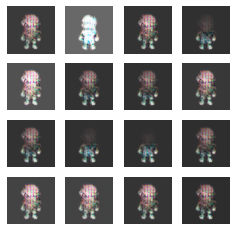

In [145]:
generator_errors, discriminator_errors = gan_train(X_train, 200)


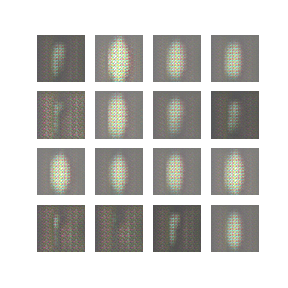

In [146]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

anim_file = 'dcgan.gif'
import glob
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
from IPython.display import Image
Image(open('dcgan.gif','rb').read())

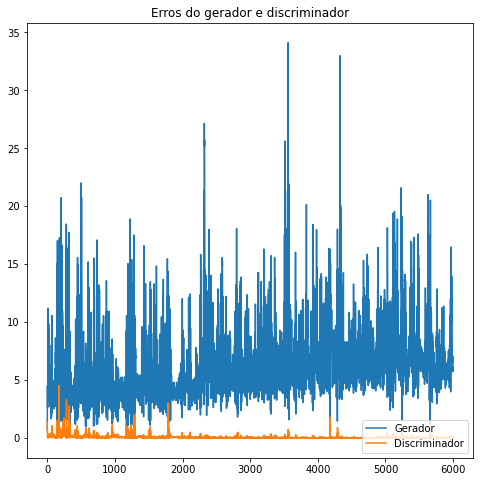

In [147]:
epochs_batches_range = range(len(generator_errors))

plt.figure(figsize=(8, 8))
plt.plot(epochs_batches_range, generator_errors, label='Gerador')
plt.plot(epochs_batches_range, discriminator_errors, label='Discriminador')
plt.legend(loc='lower right')
plt.title('Erros do gerador e discriminador')
plt.show()
